# Solutions for block H

In [1]:
import pandas
import geopandas
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed

## Task I

- Read the data

In [2]:
#url for Beijing AirBnb data
url = ("http://data.insideairbnb.com/china/beijing/beijing/"\
       "2019-08-15/visualisations/listings.csv")
abb = pandas.read_csv(url)

#Neighbourhoods geography
url = ("http://data.insideairbnb.com/china/beijing/beijing/"\
       "2019-08-15/visualisations/neighbourhoods.geojson")
neis = geopandas.read_file(url)

- Hex binning of property locations

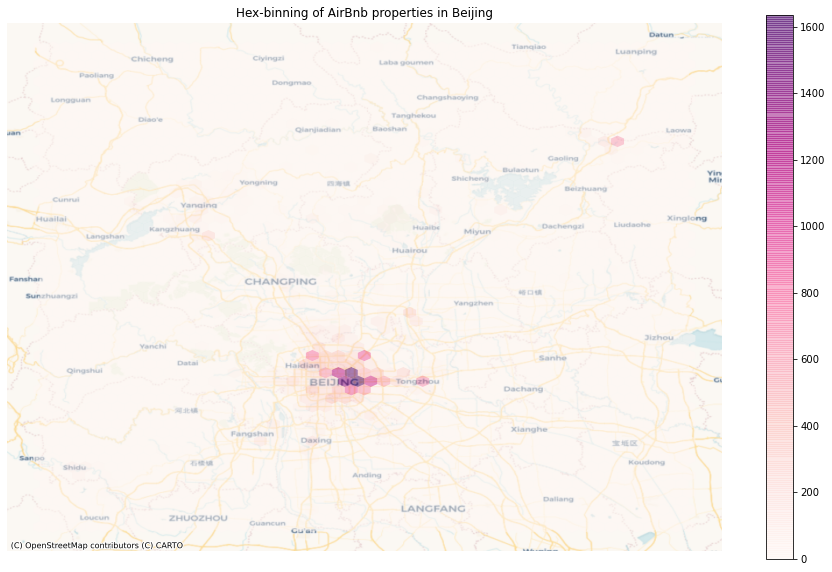

In [3]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(16, 10))
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(abb["longitude"], 
               abb["latitude"], 
               gridsize=50, 
               alpha=0.5, 
               edgecolor="none",
               cmap="RdPu"
              )
# Add a colorbar (optional)
plt.colorbar(hb)
# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(ax, 
               crs="EPSG:4326",
               source=cx.providers.CartoDB.Voyager
              )
# Add title of the map
ax.set_title("Hex-binning of AirBnb properties in Beijing")
# Draw map
plt.show()

- Compute and display a kernel density estimate (KDE) of the distribution of the properties

**NOTE** - We first randomly subset the locations to a sample of 1,000

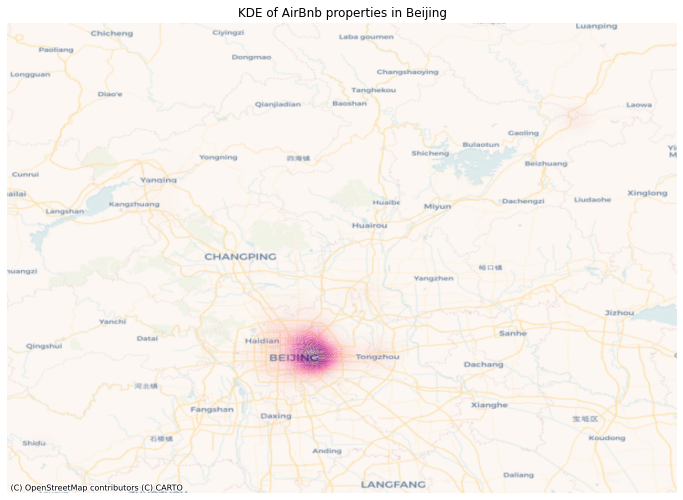

In [4]:
#Random subset to make computation faster
abb_sub = abb.sample(1000, random_state=12345)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add KDE layer that displays probability surface
sns.kdeplot(abb_sub["longitude"], 
            abb_sub["latitude"], 
            n_levels=50, 
            shade=True,
            alpha=0.25,
            cmap="RdPu"
           )
# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(ax, 
               crs="EPSG:4326",
               source=cx.providers.CartoDB.Voyager
              )
# Add title of the map
ax.set_title("KDE of AirBnb properties in Beijing")
# Draw map
plt.show()

- Neighbourhood-level

Property count:

In [5]:
nei_count = abb.groupby('neighbourhood').size()
nei_count

neighbourhood
东城区                  3414
丰台区 / Fengtai        2049
大兴区 / Daxing         1051
密云县 / Miyun          1565
平谷区 / Pinggu          208
延庆县 / Yanqing        2169
怀柔区 / Huairou        1226
房山区                   810
昌平区                  1393
朝阳区 / Chaoyang      11816
海淀区                  3524
石景山区                  252
西城区                  1935
通州区 / Tongzhou       1467
门头沟区 / Mentougou      221
顺义区 / Shunyi         1300
dtype: int64

Choropleth of the raw count:

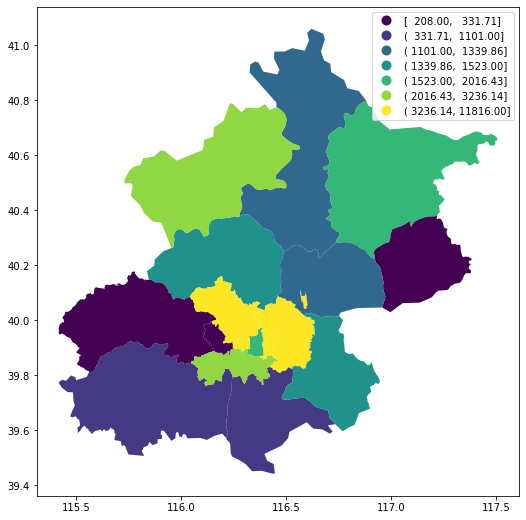

In [6]:
neis.set_index("neighbourhood")\
    .assign(abb_count=nei_count)\
    .plot(column="abb_count",
          scheme="quantiles",
          k=7,
          legend=True,
          figsize=(9, 9)
         );

Choropleth of density:

**NOTE** - We use a [projection](http://epsg.io/4589) suitable for Beijing and expressed in metres

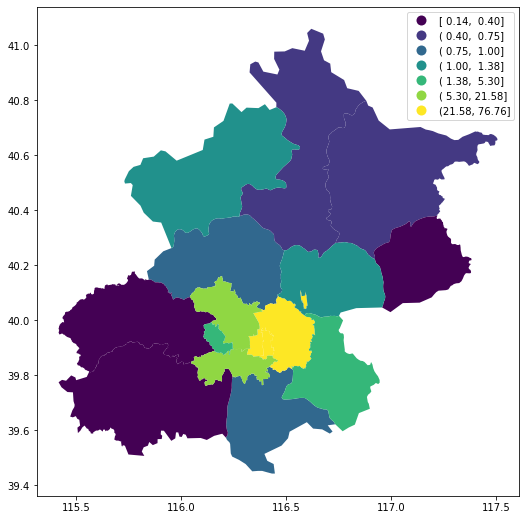

In [7]:
# Note we calculate areas in Sq. metres and then convert to Sq. Km
density = nei_count / neis.set_index("neighbourhood")\
                          .to_crs(epsg=4589)\
                          .area * 1e6
neis.set_index("neighbourhood")\
    .assign(abb_density=density)\
    .plot(column="abb_density",
          scheme="quantiles",
          k=7,
          legend=True,
          figsize=(9, 9)
         );

## Task II

Use the DBSCAN algorithm to identify clusters

In [8]:
# Setup the path to your data
url = ("https://d2ad6b4ur7yvpq.cloudfront.net/"\
       "naturalearth-3.3.0/"\
       "ne_50m_populated_places_simple.geojson"
      )

# Read your data in a GeoPandas DataFrame and crop it to only show places for India as the original
# data set covers the whole world. 
places = geopandas.read_file(url).query("adm0name == 'India'")

# Change the Coordinate Reference system 
places_m = places.to_crs(epsg=24378)
places_m.crs

<Projected CRS: EPSG:24378>
Name: Kalianpur 1975 / India zone I
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: India - north of 28°N
- bounds: (70.35, 28.0, 81.64, 35.51)
Coordinate Operation:
- name: India zone I (1975 metres)
- method: Lambert Conic Conformal (1SP)
Datum: Kalianpur 1975
- Ellipsoid: Everest 1830 (1975 Definition)
- Prime Meridian: Greenwich

A bit more prep for the task:

In [9]:
# Write the X and Y coordinates of the points into separate columns
places_m['X'] = places_m.geometry.x
places_m['Y'] = places_m.geometry.y

- Start with the following parameters: at least five cities for a cluster (`min_samples`) and a maximum of 1,000Km (`eps`)

In [10]:
# Set up algorithm with distance = 1000 km and minimum of 5 cities
algo = DBSCAN(eps=1000000, min_samples=5)

Note how, since our CRS is expressed in metres, we need to convert 1,000km into metres (1,000,000).

Now let's fit it to our data:

In [11]:
# Fit the algorithm to the dataframe coordinates
algo.fit(places_m[['X','Y']])

# Assign the labels
lbls = pandas.Series(algo.labels_, index=places_m.index)

And explore the output:

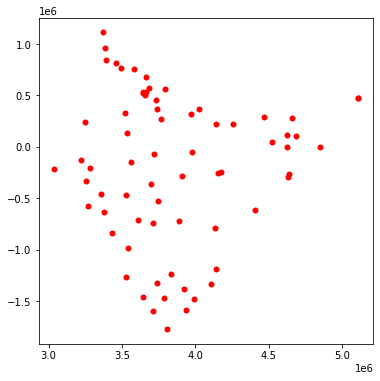

In [12]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = places_m.assign(lbls=lbls)\
             .query("lbls == -1")
# Plot noise in grey
ax.scatter(noise["X"], 
           noise["Y"], 
           c='grey', 
           s=5, 
           linewidth=0
          )
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(places_m.loc[places_m.index.difference(noise.index), 
                     "X"
                    ], 
           places_m.loc[places_m.index.difference(noise.index), 
                     "Y"
                    ],
           c="red", 
           linewidth=0
          )
# Display the figure
plt.show()

Because our `eps` is large and our `min_samples` small, every city is part of a (the same) cluster. This is not *wrong*, but it's also not very useful in terms of understanding and partitioning our data.

If you have spent enough time tweaking the values of the parameters, you may have arrived at more interesting results. Rather than posting a single solution, here we will explore how to generate an interactive widget that allows us to tinker with values and get responses without writing code in-between.

```{admonition} Note
:class: tip

The following is more advanced than expected for the level of the course and is only provided as an illustration of what is possible to do with a bit more Python chops. If it helps you learn new concepts, great! If it doesn't, do not worry, this is beyond the programming scope of the course.
```

We first need to define a function that'll cluster the points for us with a given pair of parameters:

In [13]:
def clusters(db, eps, min_samples):
    '''
    Compute and visualize DBSCAN clusters    
    ...
    
    Arguments
    ---------
    db          : (Geo)DataFrame
                  Table with at least columns `X` and `Y` for point coordinates
    eps         : float
                  Maximum radious to search for points within a cluster
    min_samples : int
                  Minimum number of points in a cluster
    '''
    algo = DBSCAN(eps=eps, min_samples=min_samples)
    algo.fit(db[['X', 'Y']])
    lbls = pandas.Series(algo.labels_, index=db.index)

    f, ax = plt.subplots(1, figsize=(6, 6))
    noise = db.loc[lbls==-1, ['X', 'Y']]
    ax.scatter(noise['X'], noise['Y'], c='grey', s=5, linewidth=0)
    ax.scatter(db.loc[db.index.difference(noise.index), 'X'], \
               db.loc[db.index.difference(noise.index), 'Y'], \
               c='red', 
               linewidth=0
              )
    return plt.show()

As an illustration, the solution computed above:

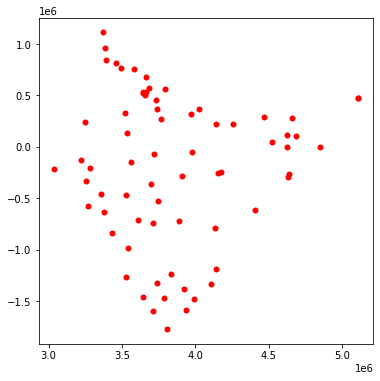

In [14]:
clusters(places_m, eps=1000000, min_samples=5)

Now we can turn it into an interactive widget with the help of `interact`:

In [15]:
interact(
    clusters,                   # Method to make interactive
    db=fixed(places_m),         # Data to pass on db (does not change)
    eps=(50000, 600000, 25000), # Range start/end/step of eps
    min_samples=(2, 30, 5)      # Range start/end/step of min_samples
);

interactive(children=(IntSlider(value=325000, description='eps', max=600000, min=50000, step=25000), IntSlider…